In [45]:
import os
import shutil

In [46]:
source_path = os.getcwd()
source_dataset = os.path.join(source_path, 'dataset')



PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'

files = {
    'PIPELINE_CONFIG':os.path.join(source_path, 'my_model', 'pipeline.config'),
    'LABELMAP': os.path.join(source_path, 'data', 'label_map.pbtxt'),
    'ANNOTATION_PATH': os.path.join(source_path, 'data'),
    'CHECKPOINT_PATH': os.path.join(source_path, 'my_model'),
    'PRETRAINED_MODEL_PATH': os.path.join('pre-trained-models')
    
}

def create_dir(sourcepath):
    os.makedirs(files['CHECKPOINT_PATH'])
    
try:
    create_dir(source_path)
except FileExistsError:
    print("file already exist")

file already exist


In [47]:
print(files['PIPELINE_CONFIG'])

d:\BANGKIT\CAPSTONE_PROJECT\V3\my_model\pipeline.config


# Update Config For Transfer Learning


In [48]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [49]:
source = r'D:/BANGKIT/CAPSTONE_PROJECT/V3/pretrained_model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'
destination = files['CHECKPOINT_PATH']
shutil.copy(source, destination)

'd:\\BANGKIT\\CAPSTONE_PROJECT\\V3\\my_model\\pipeline.config'

In [50]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [51]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [52]:
labels = []
i = 0
for filename in os.listdir(source_dataset):
    i=i+1
    labels.append({'name':filename, 'id':i})

In [53]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(source_path,files['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(files['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(files['ANNOTATION_PATH'], 'test.record')]

In [54]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# TRAINING

In [55]:
TRAINING_SCRIPT = os.path.join('d:\TFOD\Tensorflow\models','research\object_detection\model_main_tf2.py')

In [56]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, files['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [57]:
print(command)

#RUN LEWAT TERMINAL

python d:\TFOD\Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_model --pipeline_config_path=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_model\pipeline.config --num_train_steps=2000


# Evaluate the Model

In [60]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, files['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], files['CHECKPOINT_PATH'])

In [61]:
print(command)

python d:\TFOD\Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_model --pipeline_config_path=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_model\pipeline.config --checkpoint_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_model


# Load Train Model From Checkpoint

In [62]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [64]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(files['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [65]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [66]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [69]:
IMAGE_PATH = os.path.join(source_path, 'testingimage2.jpg')

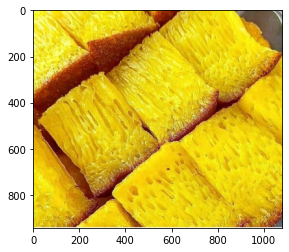

{1: {'id': 1, 'name': 'bika_ambon'}, 2: {'id': 2, 'name': 'gudeg'}, 3: {'id': 3, 'name': 'gulai_ayam'}, 4: {'id': 4, 'name': 'kerak_telor'}, 5: {'id': 5, 'name': 'klepon'}, 6: {'id': 6, 'name': 'martabak'}, 7: {'id': 7, 'name': 'nasi_tumpeng'}, 8: {'id': 8, 'name': 'pecel'}, 9: {'id': 9, 'name': 'pempek'}, 10: {'id': 10, 'name': 'rawon'}, 11: {'id': 11, 'name': 'Rendang'}, 12: {'id': 12, 'name': 'sate'}, 13: {'id': 13, 'name': 'soto'}, 14: {'id': 14, 'name': 'srabi'}, 15: {'id': 15, 'name': 'tahu_gejrot'}}


In [73]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
print(category_index)